# Purpose of tis Notebook

This notebook is used for training the test models. It inputs numpy arrays that are extracted by extract_arrays.ipynb. tHe paths to these should be entered in the FEATURES_PATH and LABELS_PATH variables.

The notebook trains the models and print the evaluate results. It also saves the models for reuse. 




In [38]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
import pickle
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

SEED = 42

In [39]:
from functions import label_others

In [40]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [41]:
FEATURES_PATH = "data/AWS_61k_TOR/tor/20_sec_features-2023_04_16__10_17_44-small.npy"
LABELS_PATH = "data/AWS_61k_TOR/tor/20_sec_labels-2023_04_16__10_17_44-df_tor.npy"
SITES_PATH = "VPN_client_scripts/urls/top_100_v2.csv"
DATA_NAME = "AWS_61k_TOR"
MODEL_TYPE = "ConvLSTM"

MIN_SITES = 150

LOAD_LB = False

TOR = True

In [42]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(27862, 200, 150, 2)

In [43]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(27862,)

In [44]:
sites_df = pd.read_csv(SITES_PATH, names=["ranking", "site", "tor_compatible"])
if TOR:
  sites_df = sites_df[sites_df["tor_compatible"] == 1] # Filters sites to only those compatable with TOR
sites = list(sites_df.site)

In [45]:
labels = label_others(labels, sites, MIN_SITES)

In [46]:
count = 0
for label in np.unique(labels, axis=0):
  print(label)
  count += 1

print(f"Num nuique = {count}")

Other
adobe.com
alibaba.com
aliexpress.com
amazon.com
avito.ru
bbc.com
bing.com
booking.com
canva.com
deepl.com
discord.com
disneyplus.com
dropbox.com
duckduckgo.com
dzen.ru
ebay.com
espn.com
etsy.com
facebook.com
fandom.com
flipkart.com
freepik.com
github.com
google.com
hbomax.com
imdb.com
instagram.com
instructure.com
linkedin.com
live.com
mail.ru
mediafire.com
microsoft.com
msn.com
myshopify.com
netflix.com
office.com
ok.ru
paypal.com
pinterest.com
primevideo.com
quora.com
rakuten.co.jp
reddit.com
roblox.com
sina.com.cn
so.com
sogou.com
spotify.com
stackoverflow.com
taobao.com
telegram.org
tiktok.com
tistory.com
twitch.tv
twitter.com
vk.com
weibo.com
whatsapp.com
wikipedia.org
wordpress.com
xnxx.com
yandex.ru
youku.com
youtube.com
zoom.us
Num nuique = 67


In [47]:
label_binariser = LabelBinarizer()
labels_encoded = label_binariser.fit_transform(labels)
del(labels)
labels_encoded.shape

(27862, 67)

In [48]:
def save_label_binarizer(encoder, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(encoder, file)

# Example usage
file_path = f'encoders/{DATA_NAME}label_binarizer.pkl'
save_label_binarizer(label_binariser, file_path)

In [49]:
# Clip the array values to a maximum of 2000
features = np.clip(features, a_min=None, a_max=2000)

In [50]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED,
    stratify=labels_encoded
)

del(features)

In [51]:
max = features_train.max()
print(max)

features_train = features_train/max
features_test = features_test/max

print(max)

495.0
495.0


In [52]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

In [53]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [54]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

In [55]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

In [56]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(30, 30))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

In [57]:
def create_convlstm_model():

    model = keras.Sequential()

    model.add(layers.ConvLSTM1D(
        filters = 4,
        kernel_size=5,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True,
        input_shape = (features_train[0].shape)
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    # Dropout layer for sequence data



    model.add(layers.ConvLSTM1D(
        filters=10,
        kernel_size=15,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=14,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=16,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    # model.add(TimeDistributed(Dropout(0.2)))


    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    
    model.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

    model.summary()

    return model

In [58]:
convlstm_model = create_convlstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_4 (ConvLSTM1D)  (None, 200, 146, 4)       496       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 200, 73, 4)       0         
 2D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 200, 73, 4)       0         
 tributed)                                                       
                                                                 
 conv_lstm1d_5 (ConvLSTM1D)  (None, 200, 59, 10)       8440      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 200, 30, 10)      0         
 2D)                                                             
                                                      

In [59]:
convlstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [60]:
convlstm_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
2090/2090 [==============================] - 4211s 2s/step - loss: 3.2675 - accuracy: 0.3880 - val_loss: 3.2182 - val_accuracy: 0.3945
Epoch 2/50
2090/2090 [==============================] - 3569s 2s/step - loss: 3.2429 - accuracy: 0.3883 - val_loss: 3.2172 - val_accuracy: 0.3945
Epoch 3/50
2090/2090 [==============================] - 2812s 1s/step - loss: 3.2405 - accuracy: 0.3883 - val_loss: 3.2162 - val_accuracy: 0.3945
Epoch 4/50
2090/2090 [==============================] - 3629s 2s/step - loss: 3.2397 - accuracy: 0.3883 - val_loss: 3.2162 - val_accuracy: 0.3945
Epoch 5/50
2090/2090 [==============================] - 2759s 1s/step - loss: 3.2400 - accuracy: 0.3883 - val_loss: 3.2125 - val_accuracy: 0.3945
Epoch 6/50
2090/2090 [==============================] - 2777s 1s/step - loss: 3.2386 - accuracy: 0.3883 - val_loss: 3.3653 - val_accuracy: 0.3945
Epoch 7/50
2090/2090 [==============================] - 2760s 1s/step - loss: 3.2370 - accuracy: 0.3883 - val_loss: 3.2162 -

Final training accuracy: 0.38825076818466187
Final validation accuracy: 0.3944976031780243


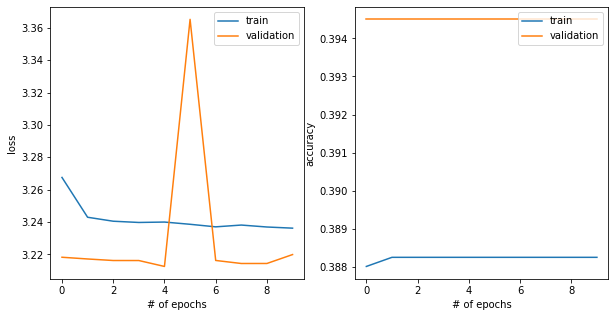

In [61]:
plot_history(convlstm_history)

In [62]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"{MODEL_TYPE}_{DATA_NAME}model_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
convlstm_model.save(os.path.join("models", model_file_name))

218/218 [==============================] - 69s 317ms/step - loss: 3.2284 - accuracy: 0.3895


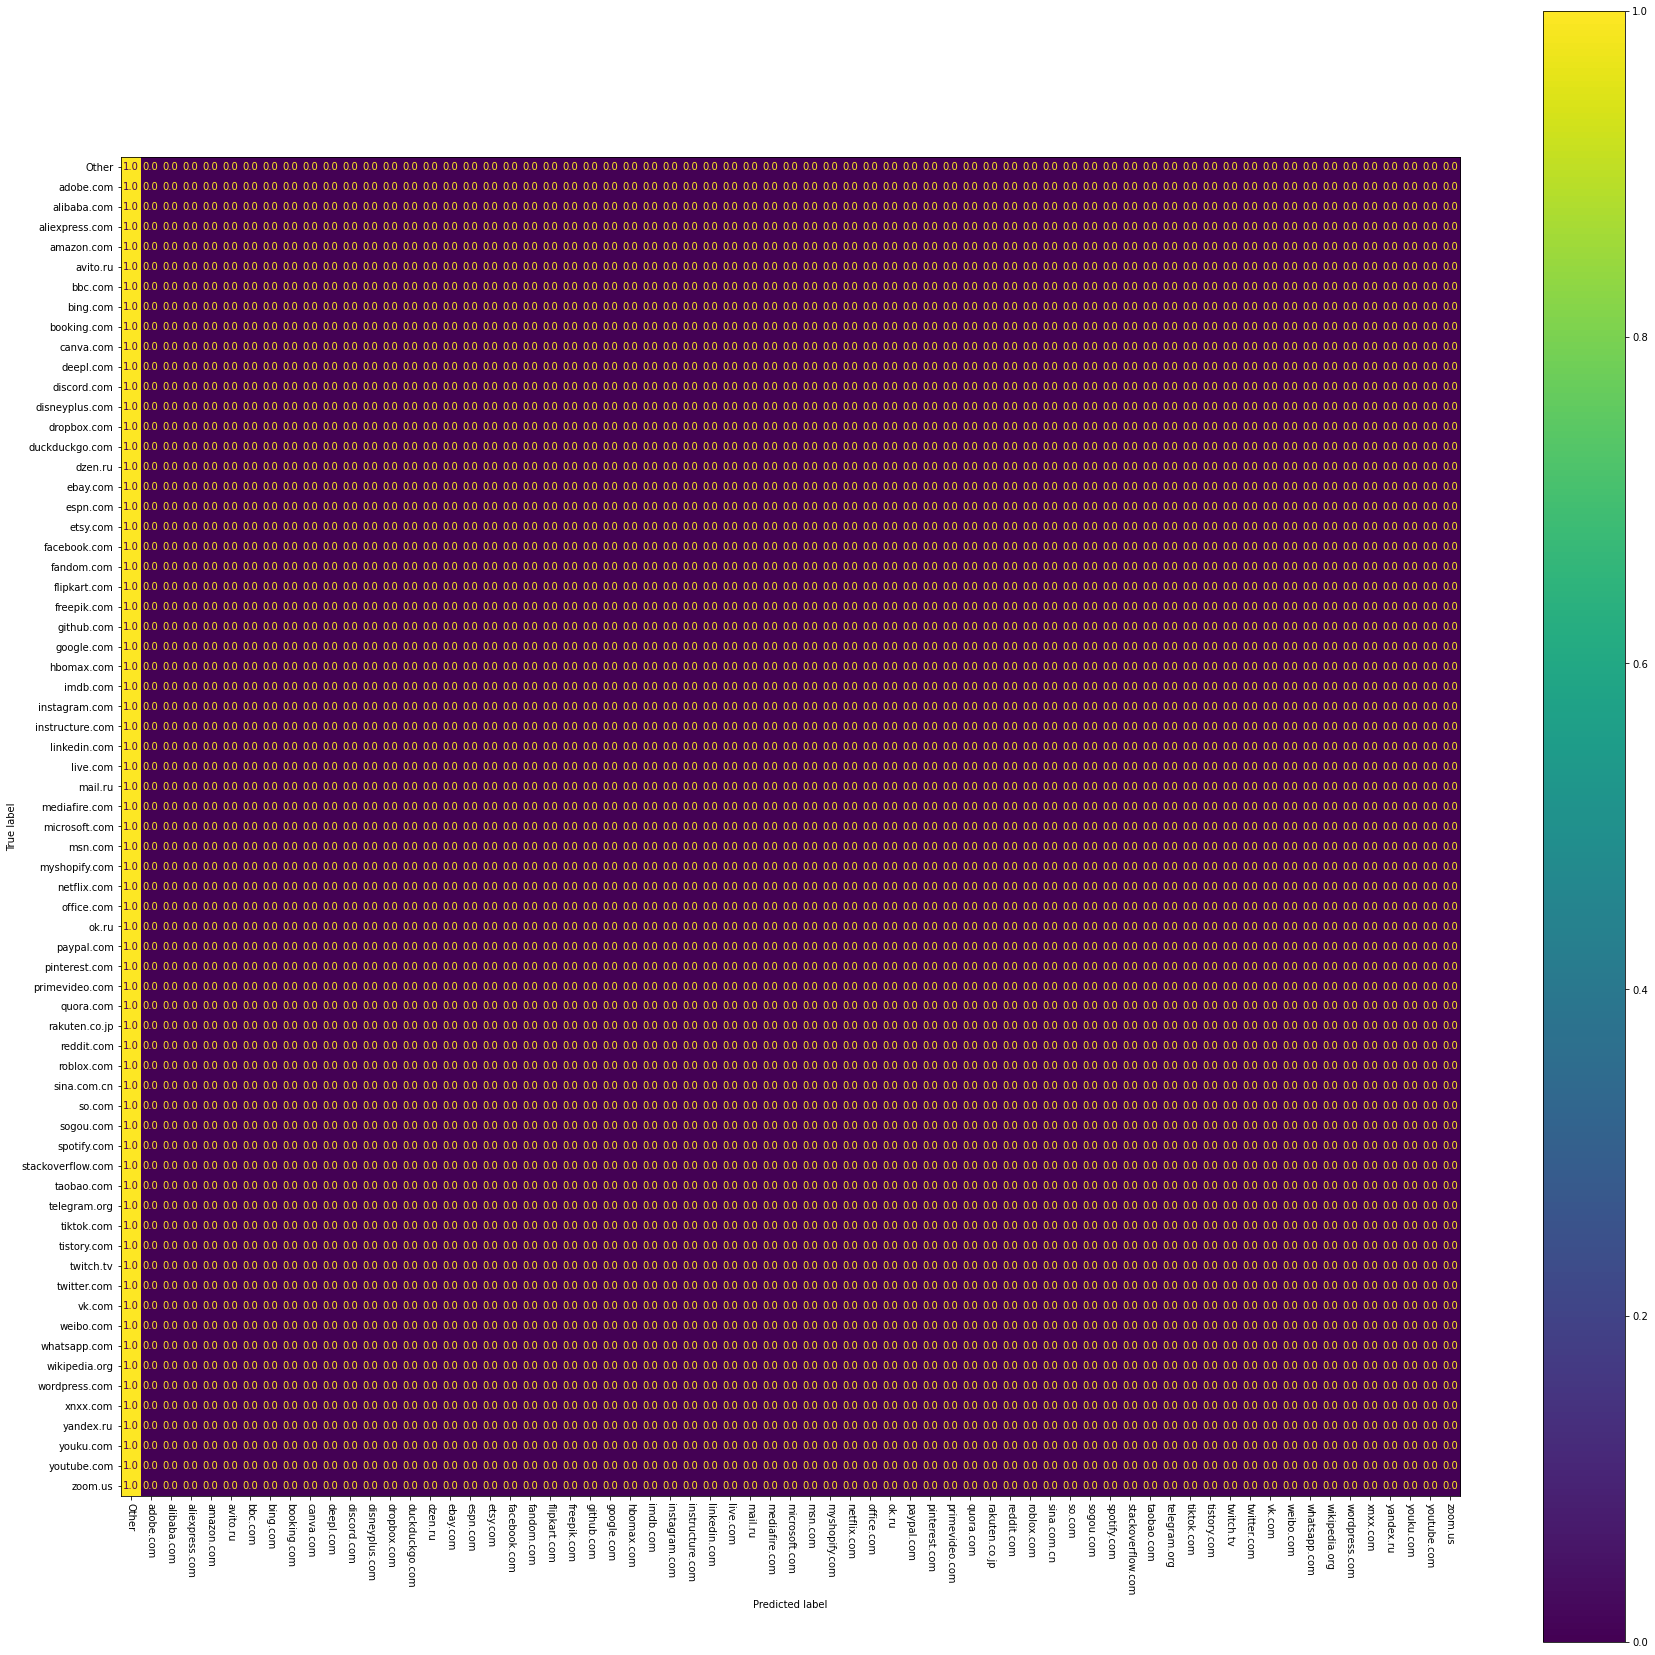

              precision    recall  f1-score   support

           0       0.39      1.00      0.56      2713
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        66
           4       0.00      0.00      0.00        70
           5       0.00      0.00      0.00        60
           6       0.00      0.00      0.00        67
           7       0.00      0.00      0.00        67
           8       0.00      0.00      0.00        66
           9       0.00      0.00      0.00        65
          10       0.00      0.00      0.00        62
          11       0.00      0.00      0.00        65
          12       0.00      0.00      0.00        65
          13       0.00      0.00      0.00        64
          14       0.00      0.00      0.00        69
          15       0.00      0.00      0.00        68
          16       0.00      0.00      0.00        72
          17       0.00    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [63]:
plot_results(convlstm_model)

In [64]:
[[x, label_binariser.classes_[x]] for x in range(unique_y.min(), len(unique_y))]

[[0, 'Other'],
 [1, 'adobe.com'],
 [2, 'alibaba.com'],
 [3, 'aliexpress.com'],
 [4, 'amazon.com'],
 [5, 'avito.ru'],
 [6, 'bbc.com'],
 [7, 'bing.com'],
 [8, 'booking.com'],
 [9, 'canva.com'],
 [10, 'deepl.com'],
 [11, 'discord.com'],
 [12, 'disneyplus.com'],
 [13, 'dropbox.com'],
 [14, 'duckduckgo.com'],
 [15, 'dzen.ru'],
 [16, 'ebay.com'],
 [17, 'espn.com'],
 [18, 'etsy.com'],
 [19, 'facebook.com'],
 [20, 'fandom.com'],
 [21, 'flipkart.com'],
 [22, 'freepik.com'],
 [23, 'github.com'],
 [24, 'google.com'],
 [25, 'hbomax.com'],
 [26, 'imdb.com'],
 [27, 'instagram.com'],
 [28, 'instructure.com'],
 [29, 'linkedin.com'],
 [30, 'live.com'],
 [31, 'mail.ru'],
 [32, 'mediafire.com'],
 [33, 'microsoft.com'],
 [34, 'msn.com'],
 [35, 'myshopify.com'],
 [36, 'netflix.com'],
 [37, 'office.com'],
 [38, 'ok.ru'],
 [39, 'paypal.com'],
 [40, 'pinterest.com'],
 [41, 'primevideo.com'],
 [42, 'quora.com'],
 [43, 'rakuten.co.jp'],
 [44, 'reddit.com'],
 [45, 'roblox.com'],
 [46, 'sina.com.cn'],
 [47, 'so.c